Whether the extent to which an individual is exposed to the COVID_19 directly correlates with the severity of the symptoms remains controversial. In the current notebook, we will investigate whether reducing the exposure to COVID-19  by wearing a mask can reduce the symptoms and thereby leading to lower death.  In doing so, we will set the ratio of monthly average deaths to monthly average cases as our parameters of interest and we call it the death ratio.
<br>
We will identify the effective date of the executive orders by the governors that required mask mandate at Pacific Coast states in the U.S and calculate the average death ratio one month before and after the order. Then we will calculate the amount of variation in the death ratio following the mask mandate order. We will categorize the variation based on its sign to quantify whether the death ratio increases, decreases, or remains the same.
<br>
In order to have a comparison between states, we will use the population to compare different counties irrespective of their states. Moreover, we believe the extent to which people abide by the mask mandate order might be correlated with their income and political inclination in different counties. We also add their mask usage according to a NewYork Times survey as the last feature.
<br>
Finally, we will try to establish an AI-based relationship between population, income, political orientation, mask usage, and variation in the death ratio. The step by step process is as the followings: 


*   Find the Mask Mandate (MM) order's effective date for the states of interest.
*   Find the COIVD-19 data daily cases and deaths data for a month before and after the MM order.
*   Find the population, income, political inclination, and mask usage data for the states of interest at the county level.
*     Read the data using Pandas.
*     Categorize the data based on the sign of the variation in death ratio.
*    Use 9 different classification algorithm to train data and predict the variations in the death ratio based on the aforementioned features.



In [ ]:
#import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import time     # this library provides various time related functions like current time, date etc.

In [ ]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Read the initial data for different states
data_CA=pd.read_csv("/content/drive/My Drive/AI_Thermal sytems_course_project/California/Data_California_copy.csv")#California
data_WA=pd.read_csv("/content/drive/My Drive/AI_Thermal sytems_course_project/Washington/Data_Washington_copy.csv")#Washington
data_OR=pd.read_csv("/content/drive/My Drive/AI_Thermal sytems_course_project/Oregon/Data_Oregon_copy.csv")#Oregon
dc=[data_WA, data_OR, data_CA]
data_tot=pd.concat(dc,ignore_index=True)# Merge datas of different states
data_tot.sort_values('County',inplace=True)# Sort alphabetically
data_tot.reset_index(inplace=True,drop=True)# reset the indexing
from pandas.api.types import CategoricalDtype # import module required to make a categorical data
status_type = CategoricalDtype(categories=['increase', 'decrease','no change'], ordered=True) #define your items as categories
data_tot['status of the change'] = data_tot['status of the change'].astype(status_type)
#data_tot.drop(columns=['Population density (person/km^2)','Area (sq mile)','1_months_before_order deaths/cases percentage' ,'1_months_after_order deaths/cases percentage','BIDEN PCT','TRUMP PCT'],inplace=True)
#data_tot.head(5)
data_tot_copy = data_tot.copy(deep=True)

In [ ]:
data_tot.dtypes

County                                             object
Population                                        float64
Area (sq km)                                      float64
Population density (person/km^2)                  float64
High school percentage                            float64
Persons per household                             float64
Persons in poverty percentage                     float64
Median income                                     float64
Biden won                                           int64
Trump won                                           int64
Never                                             float64
Rarely                                            float64
Sometimes                                         float64
Frequently                                        float64
Always                                            float64
1_months_before_order deaths/cases percentage     float64
1_months_after_order deaths/cases percentage      float64
change in deat

In [ ]:
#data_tot.replace([np.inf, -np.inf], np.nan,inplace=True)
#data_tot.dropna(inplace=True)
data_tot.describe()

,Population,Area (sq km),Population density (person/km^2),High school percentage,Persons per household,Persons in poverty percentage,Median income,Biden won,Trump won,Never,Rarely,Sometimes,Frequently,Always,1_months_before_order deaths/cases percentage,1_months_after_order deaths/cases percentage,change in deaths/cases percentage
count,1.300000e+02,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,3.903071e+05,6275.789030,150.642998,87.054615,2.608308,12.916923,61403.500000,0.423077,0.576923,0.035331,0.038262,0.071508,0.174492,0.680292,0.994753,0.715021,-0.279733
std,1.037801e+06,6525.471194,664.180979,6.576740,0.363344,3.619438,16712.599359,0.495959,0.495959,0.028952,0.034571,0.037053,0.054979,0.096594,1.840788,1.227060,2.184181
min,1.129000e+03,121.392831,0.274595,66.900000,2.030000,6.100000,37898.000000,0.000000,0.000000,0.001000,0.000000,0.004000,0.058000,0.305000,0.000000,0.000000,-12.903226
25%,2.446750e+04,2487.452296,5.166023,84.575000,2.342500,10.600000,51109.250000,0.000000,0.000000,0.016000,0.014000,0.048000,0.141500,0.615250,0.000000,0.000000,-0.775084
50%,7.830900e+04,4462.552770,18.625742,89.250000,2.515000,12.650000,55952.000000,0.000000,1.000000,0.026000,0.028000,0.069000,0.168500,0.679500,0.000000,0.343842,0.000000
75%,2.817532e+05,7698.557501,61.052002,91.475000,2.810000,15.175000,67022.250000,1.000000,1.000000,0.045000,0.056750,0.090500,0.204000,0.753750,1.586655,1.010384,0.000000
max,1.003911e+07,51947.274030,7261.952708,95.900000,3.870000,26.300000,124055.000000,1.000000,1.000000,0.140000,0.206000,0.213000,0.332000,0.889000,12.903226,7.692308,7.692308


In [ ]:
#Drop the rows with no change in their status of the change

#data_tot.replace('no change', np.nan,inplace=True)
#data_tot.dropna(inplace=True)
data_tot.drop(data_tot.loc[data_tot['status of the change']=='no change'].index, inplace=True)
data_tot.head(5)
#data_tot.shape

,County,Population,Area (sq km),Population density (person/km^2),High school percentage,Persons per household,Persons in poverty percentage,Median income,Biden won,Trump won,Never,Rarely,Sometimes,Frequently,Always,1_months_before_order deaths/cases percentage,1_months_after_order deaths/cases percentage,change in deaths/cases percentage,status of the change
0,Adams County,19983.0,4985.730750,4.008038,66.9,3.26,16.8,48294.0,0,1,0.077,0.051,0.072,0.076,0.724,0.000000,0.431034,0.431034,increase
1,Alameda County,1671329.0,1914.054410,873.187821,88.4,2.81,8.9,99406.0,1,0,0.019,0.008,0.055,0.123,0.795,1.541336,1.040462,-0.500873,decrease
6,Benton County,93053.0,1750.833240,53.147837,95.9,2.40,16.5,62077.0,1,0,0.007,0.007,0.059,0.156,0.770,0.000000,1.612903,1.612903,increase
7,Benton County,204390.0,4402.983000,46.420802,90.2,2.71,10.6,69023.0,0,1,0.084,0.011,0.064,0.080,0.761,1.877934,1.837769,-0.040165,decrease
8,Butte County,219186.0,4238.415035,51.714143,89.2,2.55,16.1,52537.0,1,0,0.015,0.043,0.111,0.204,0.626,1.470588,0.694444,-0.776144,decrease


In [ ]:
#Drop the row containing a death rate greater than 100%
data_tot.drop(data_tot.loc[data_tot["1_months_before_order deaths/cases percentage"] > 100].index, inplace=True)
data_tot.describe()

,Population,Area (sq km),Population density (person/km^2),High school percentage,Persons per household,Persons in poverty percentage,Median income,Biden won,Trump won,Never,Rarely,Sometimes,Frequently,Always,1_months_before_order deaths/cases percentage,1_months_after_order deaths/cases percentage,change in deaths/cases percentage
count,7.700000e+01,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,6.304135e+05,6844.577337,243.934762,85.327273,2.749610,12.550649,66494.233766,0.558442,0.441558,0.031104,0.031234,0.064455,0.165260,0.707883,1.679454,1.207178,-0.472276
std,1.297275e+06,7462.430733,852.183082,7.267169,0.333677,3.712661,18484.921518,0.499829,0.499829,0.023733,0.030032,0.033517,0.046248,0.090621,2.141607,1.397765,2.829384
min,7.208000e+03,121.392831,0.274595,66.900000,2.150000,6.100000,43313.000000,0.000000,0.000000,0.001000,0.000000,0.004000,0.069000,0.305000,0.000000,0.000000,-12.903226
25%,8.608500e+04,2628.036953,15.237220,80.900000,2.470000,9.500000,53105.000000,0.000000,0.000000,0.016000,0.013000,0.041000,0.136000,0.666000,0.000000,0.473485,-1.398646
50%,2.191860e+05,4612.772190,46.420802,88.100000,2.690000,12.600000,62077.000000,1.000000,0.000000,0.024000,0.023000,0.059000,0.159000,0.724000,1.371308,0.812660,-0.443535
75%,6.015920e+05,8496.721194,152.088064,91.100000,2.970000,14.000000,74624.000000,1.000000,1.000000,0.041000,0.043000,0.080000,0.197000,0.768000,2.244389,1.363326,0.769231
max,1.003911e+07,51947.274030,7261.952708,95.900000,3.870000,22.000000,124055.000000,1.000000,1.000000,0.106000,0.206000,0.213000,0.297000,0.865000,12.903226,7.692308,7.692308


{0: 'increase', 1: 'decrease', 2: 'no change'}


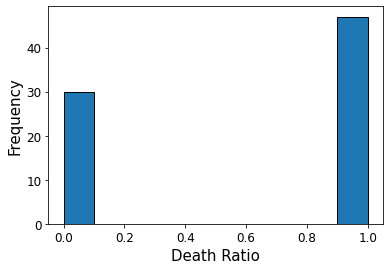

In [ ]:
#initial assessment of the data by histogram 
plt.hist(data_tot['status of the change'].cat.codes,edgecolor="black")
csfont = {'fontname':'Times New Roman'}
plt.xlabel("Death Ratio", **csfont, fontsize=15)
plt.ylabel('Frequency', **csfont, fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
import os
os.chdir('/content/drive/My Drive/AI_Thermal sytems_course_project/figures')
plt.savefig('classes_histogram.eps', bbox_inches = 'tight', pad_inches = 0)
d_stat = dict(enumerate(data_tot['status of the change'].cat.categories))
print(d_stat)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


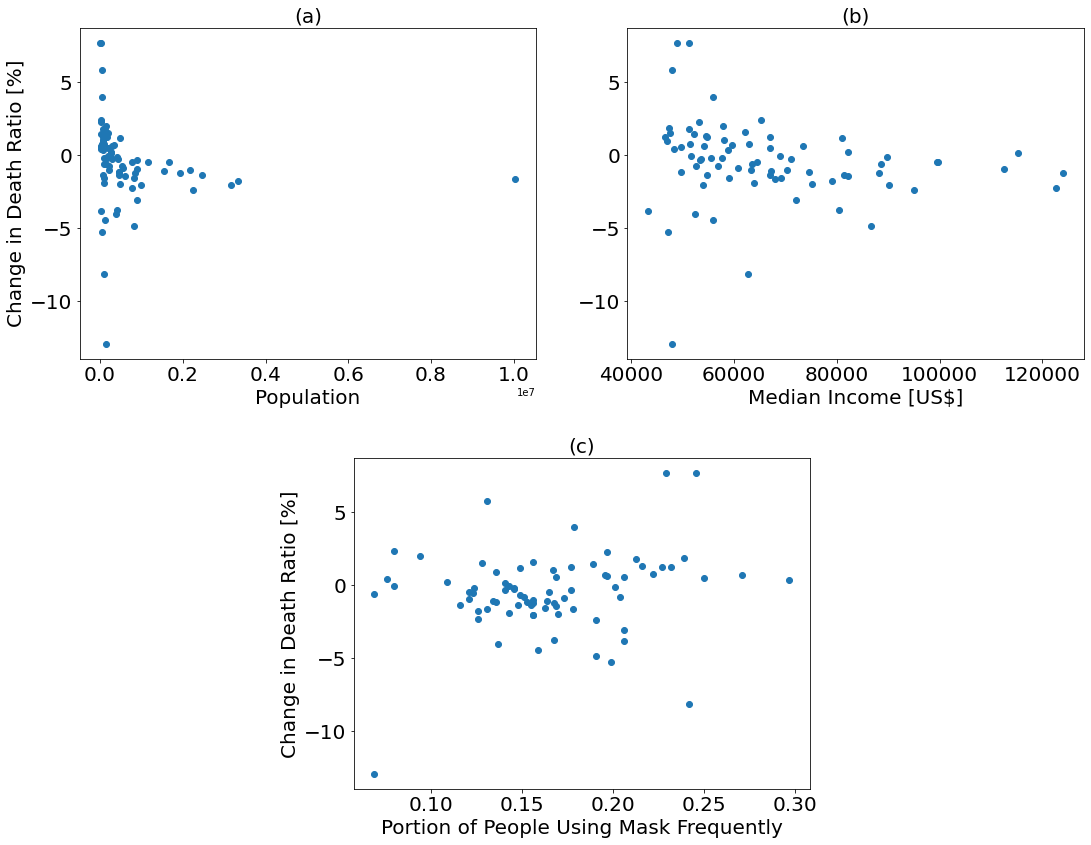

In [ ]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18,14))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5,hspace=0.3)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, 1:3])
fs=20
ax1.scatter(data_tot['Population'].values,data_tot['change in deaths/cases percentage'])
ax1.set_xlabel("Population",**csfont,fontsize=fs)
ax1.set_ylabel("Change in Death Ratio [%]",**csfont,fontsize=fs)
ax1.set_title('(a)',**csfont,fontsize=fs)
ax1.tick_params(axis='x', labelsize= fs)
ax1.tick_params(axis='y', labelsize= fs)
ax2.scatter(data_tot['Median income'].values,data_tot['change in deaths/cases percentage'])
#ax2.set_ylabel("Change in Death Ratio [%]",**csfont,fontsize=20)
ax2.set_xlabel("Median Income [US$]",**csfont,fontsize=fs)
ax2.set_title('(b)',**csfont,fontsize=fs)
ax2.tick_params(axis='x', labelsize= fs)
ax2.tick_params(axis='y', labelsize= fs)

ax3.scatter(data_tot['Frequently'].values,data_tot['change in deaths/cases percentage'])
ax3.set_ylabel("Change in Death Ratio [%]",**csfont,fontsize=fs)
ax3.set_xlabel("Portion of People Using Mask Frequently",**csfont,fontsize=fs)
ax3.set_title('(c)',**csfont,fontsize=fs)
ax3.tick_params(axis='x', labelsize= fs)
ax3.tick_params(axis='y', labelsize= fs)
import os
fig.tight_layout()
os.chdir('/content/drive/My Drive/AI_Thermal sytems_course_project/figures')
plt.savefig('all_scatter_2.png', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
#initial assessment of data by scatter plotting
print(data_tot_copy['status of the change'].value_counts())
#s1='Population'
#s2='Median household income (in 2018 dollars)'
#plt.scatter(data_tot[s1],data_tot[s2],c=data_tot['status of the change'].cat.codes) 
d_stat = dict(enumerate(data_tot['status of the change'].cat.categories))
print (d_stat)
#plt.xlabel(s1)
#plt.ylabel(s2)

no change    53
decrease     47
increase     30
Name: status of the change, dtype: int64
{0: 'increase', 1: 'decrease', 2: 'no change'}


In [ ]:
#x=data_tot[['Population density (person/km^2)','percentage_of_the_population_completing_college']]#define your input data
#x=data_tot.drop(columns=['1_months_before_order deaths/cases percentage', '1_months_after_order deaths/cases percentage', 'change in deaths/cases percentage', 'status of the change','County'])
x=data_tot.drop(columns=['1_months_before_order deaths/cases percentage', '1_months_after_order deaths/cases percentage', 'change in deaths/cases percentage', 'Area (sq km)', 'Population density (person/km^2)', 'status of the change','County', "Persons in poverty percentage", 'High school percentage', 'Persons per household'])
#x=data_tot.drop(columns=['1_months_before_order deaths/cases percentage', '1_months_after_order deaths/cases percentage', 'change in deaths/cases percentage', 'status of the change', 'percentage_of_the_population_completing_college', 'Per capita income in past 12 months (in 2018 dollars)', 'County', 'Area (sq mile)'])
y1=data_tot[['change in deaths/cases percentage']]#define your output data one
y2=data_tot['status of the change'].cat.codes

In [ ]:
x.dtypes

Population       float64
Median income    float64
Biden won          int64
Trump won          int64
Never            float64
Rarely           float64
Sometimes        float64
Frequently       float64
Always           float64
dtype: object

In [ ]:
#scaling data
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
max_abs_scaler = MaxAbsScaler()
x_scaled=min_max_scaler.fit_transform(x) #scale the positive values
y1_scaled=max_abs_scaler.fit_transform(y1)# scale the values that are both positive and negative

In [ ]:
#creating data from scaled files 
#del data_class
#del data_t
data_class = pd.concat([pd.DataFrame(x_scaled), pd.DataFrame(y2)], axis=1)
#data_class.columns=['Population','Area (sq km)', 'Population density (person/km^2)', 'High school percentage','Persons per household', 'Persons in poverty percentage', 'Median income','Biden won', 'Trump won', 'Never', 'Rarely', 'Sometimes', 'Frequently', 'Always', 'status of the change']
data_class.columns=['Population', 'Median income','Biden won', 'Trump won', 'Never', 'Rarely', 'Sometimes', 'Frequently', 'Always', 'status of the change']
data_t = pd.concat([pd.DataFrame(x_scaled), pd.DataFrame(y1_scaled)], axis=1)
#data_t.columns=['Population','Area (sq km)', 'Population density (person/km^2)', 'High school percentage','Persons per household', 'Persons in poverty percentage', 'Median income','Biden won', 'Trump won', 'Never', 'Rarely', 'Sometimes', 'Frequently', 'Always', 'change in deaths/cases percentage ']
data_t.columns=['Population', 'Median income','Democrat', 'Republican', 'Never', 'Rarely', 'Sometimes', 'Frequently', 'Always', '\u0394DR']
#data_class.head(5)
#print ('Delta: \u0394')

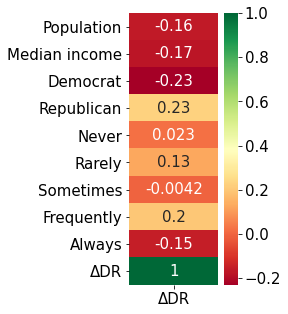

In [ ]:
import seaborn as sns
plt.figure(figsize=(2,5))  # set the size of the figure 
sns.set_style({'font.family': 'Times New Roman'})
#p=sns.heatmap(data_t.iloc[:,0:].corr(), annot=True,cmap ='RdYlGn', annot_kws={"size":12})
p = sns.heatmap(data_t.corr().loc[: , ['\u0394DR']], annot=True,cmap ='RdYlGn', annot_kws={"size":15})
p.tick_params(axis='y', labelsize= 15)
p.tick_params(axis='x', labelsize= 15)
cbar = p.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
import os
os.chdir('/content/drive/My Drive/AI_Thermal sytems_course_project/figures')
#plt.savefig('correlations.eps', bbox_inches = 'tight', pad_inches = 0)
plt.savefig('output_features_correlations.png', bbox_inches = 'tight', pad_inches = 0)

# **Classification Models**

**Naive Bayes**

In [ ]:
#split the data into train and test. Test data=1/5(total data)
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split 
X_train,X_test,y_train,y_test = train_test_split(x_scaled,y2,test_size=1/5,random_state=27, shuffle=True)

#create an instance of GaussianNB class
model=GaussianNB()
#model=MultinomialNB()

#fit the training data 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_hat = model.predict(X_train)
print("Number of mislabeled points out of a total %d points : %d"  % (X_test.shape[0], (y_test != y_pred).sum()))

# you get the conditional probabilities

Number of mislabeled points out of a total 16 points : 1


In [ ]:
#compute our score to evaluate the performance of the fitting
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred) 
print('score_test=',score)
score = accuracy_score(y_train, y_hat) 
print('score_train=',score)

score_test= 0.9375
score_train= 0.7049180327868853


              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.90      0.95        10

    accuracy                           0.94        16
   macro avg       0.93      0.95      0.94        16
weighted avg       0.95      0.94      0.94        16



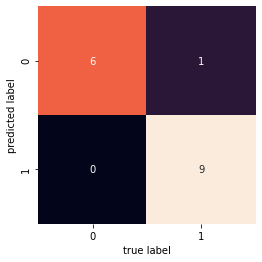

In [ ]:
#build a confusion matrix to visualize the performance of the model using seaborn
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');
os.chdir('/content/drive/My Drive/AI_Thermal sytems_course_project/figures')
plt.savefig('confusion_matrix_NB.png', bbox_inches = 'tight', pad_inches = 0)

**Suport Vector Machine**

In [ ]:
#Build a support vector machine model
from sklearn import svm
model = svm.SVC(kernel='rbf',C=1,max_iter=1000) #define an instance of SVC class
'''
kernel=Define the non-linear kernel to be used
degree= specify the degree for polynomial kernel
C= penalty term. It is the inverse of regularization coefficient. 
max_iter=maximum iterations to perform.
'''
model.fit(X_train,y_train)  #fit the model on train data and label

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
#Tune the hyper parameters using the grid search
from sklearn.model_selection import GridSearchCV
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'linear', 'poly'],
              'degree': [2, 3, 4, 5]}  
  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 0, cv = 5) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'degree': [2, 3, 4, 5],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1000, 'degree': 2, 'gamma': 1, 'kernel': 'linear'}
SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
model_tuned = svm.SVC(kernel='linear', degree = 2, C=1000,max_iter=1000, gamma = 1)
model_tuned.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=1, kernel='linear',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_hat = model_tuned.predict(X_train)
y_pred = model_tuned.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"  % (X_test.shape[0], (y_test != y_pred).sum()))
# you get the conditional probabilities

Number of mislabeled points out of a total 16 points : 3


In [ ]:
#compute our score to evaluate the performance of the fitting
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred) 
print('score_test=',score)
score = accuracy_score(y_train, y_hat) 
print('score_train=',score)
#print (y_test)

score_test= 0.8125
score_train= 0.819672131147541


              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.82      0.90      0.86        10

    accuracy                           0.81        16
   macro avg       0.81      0.78      0.79        16
weighted avg       0.81      0.81      0.81        16



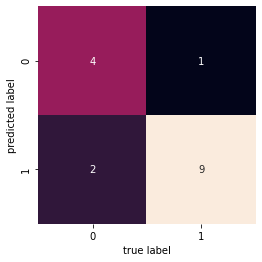

In [ ]:
#build a confusion matrix to visualize the performance of the model using seaborn
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');
os.chdir('/content/drive/My Drive/AI_Thermal sytems_course_project/figures')
plt.savefig('confusion_matrix_SVM.png', bbox_inches = 'tight', pad_inches = 0)

**Random Forest**

In [ ]:
#Use grid search to come up with best set of parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf_params = {"max_depth": [2, 3, 5, 7, 8],
            "max_features": [2, 3, 5, 7, 8],
            "n_estimators": [10,500,1000],
            "min_samples_split": [2,5,10]}

rf_model = RandomForestClassifier(random_state = 27)

rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 5, 
                           n_jobs = -1, 
                           verbose = 2) 

rf_cv_model.fit(X_train, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed: 11.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=27,
                                  

In [ ]:
print("Best Params: " + str(rf_cv_model.best_params_))

Best Params: {'max_depth': 7, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 10}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_tuned = RandomForestClassifier(random_state = 27, max_depth = 7, 
                                  max_features = 2, 
                                  min_samples_split = 2,
                                  n_estimators = 10)
rf_tuned.fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)
print ('test accuracy:', accuracy_score(y_test, y_pred))
print("Number of mislabeled points out of a total %d points : %d"  % (X_test.shape[0], (y_test != y_pred).sum()))
y_hat = rf_tuned.predict(X_train)
#compute our score to evaluate the performance of the fitting
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred) 
print('score_test=',score)
score = accuracy_score(y_train, y_hat) 
print('score_train=',score)

test accuracy: 0.9375
Number of mislabeled points out of a total 16 points : 1
score_test= 0.9375
score_train= 1.0


              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.91      1.00      0.95        10

    accuracy                           0.94        16
   macro avg       0.95      0.92      0.93        16
weighted avg       0.94      0.94      0.94        16



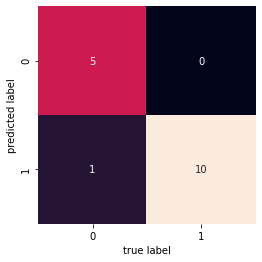

In [ ]:
#build a confusion matrix to visualize the performance of the model using seaborn
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.savefig('confusion_matrix_RF.png', bbox_inches = 'tight', pad_inches = 0)

**Decision Tree**

In [ ]:
#Build a Decision tree model
from sklearn import tree
dec_tree = tree.DecisionTreeClassifier(random_state=27)
dec_tree = dec_tree.fit(X_train, y_train)

In [ ]:
#Use grid search to come up with best set of parameters
def Snippet_146_Ex_2():
    print('**Optimizing hyper-parameters of a Decision Tree model using Grid Search in Python**\n')


    # importing libraries
    from sklearn import decomposition, datasets
    from sklearn import tree
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import StandardScaler

    # Creating an standardscaler object
    std_slc = StandardScaler()

    # Creating a pca object
    pca = decomposition.PCA()

    # Creating a DecisionTreeClassifier
    dec_tree = tree.DecisionTreeClassifier(random_state=27)

    # Creating a pipeline of three steps. First, standardizing the data.
    # Second, tranforming the data with PCA.
    # Third, training a Decision Tree Classifier on the data.
    pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('dec_tree', dec_tree)])

    # Creating Parameter Space
    # Creating a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
    n_components = list(range(1,X_train.shape[1]+1,1))

    # Creating lists of parameter for Decision Tree Classifier
    criterion = ['gini', 'entropy']
    max_depth = [2,4,6,8,10,12]
    min_samples_split = [2, 3]

    # Creating a dictionary of all the parameter options 
    # Note that we can access the parameters of steps of a pipeline by using '__’
    parameters = dict(pca__n_components=n_components,
                      dec_tree__criterion=criterion,
                      dec_tree__max_depth=max_depth,
                      dec_tree__min_samples_split=min_samples_split)

    # Conducting Parameter Optmization With Pipeline
    # Creating a grid search object
    clf_GS = GridSearchCV(pipe, parameters)

    # Fitting the grid search
    clf_GS.fit(X_train, y_train)

    # Viewing The Best Parameters
    print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
    print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
    print('Best min_samples_split:', clf_GS.best_estimator_.get_params()['dec_tree__min_samples_split'])
    print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
    print(); print(clf_GS.best_estimator_.get_params()['dec_tree'])

   
Snippet_146_Ex_2()

**Optimizing hyper-parameters of a Decision Tree model using Grid Search in Python**

Best Criterion: entropy
Best max_depth: 8
Best min_samples_split: 2
Best Number Of Components: 3

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=27, splitter='best')


test accuracy: 0.8125
Number of mislabeled points out of a total 16 points : 3
train accuracy: 1.0


Text(0, 0.5, 'frequency')

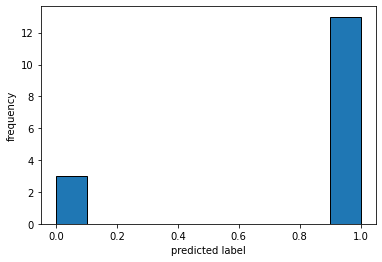

In [ ]:
from sklearn import tree
dec_tree_tuned = tree.DecisionTreeClassifier(random_state=27, max_depth = 8, 
                                  #max_features = 8, 
                                  criterion = 'entropy',
                                  min_samples_split = 2
                                  #n_components = 1
                                  )
dec_tree_tuned.fit(X_train, y_train)
y_pred = dec_tree_tuned.predict(X_test)
print ('test accuracy:', accuracy_score(y_test, y_pred))
print("Number of mislabeled points out of a total %d points : %d"  % (X_test.shape[0], (y_test != y_pred).sum()))
y_hat = dec_tree_tuned.predict(X_train)
print ('train accuracy:', accuracy_score(y_train, y_hat))
plt.hist(y_pred,edgecolor="black")
plt.xlabel("predicted label")
plt.ylabel('frequency')

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.77      1.00      0.87        10

    accuracy                           0.81        16
   macro avg       0.88      0.75      0.77        16
weighted avg       0.86      0.81      0.79        16



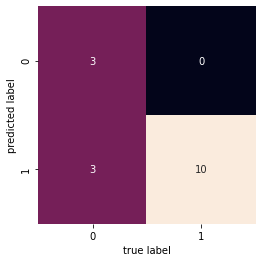

In [ ]:
#build a confusion matrix to visualize the performance of the model using seaborn
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');
os.chdir('/content/drive/My Drive/AI_Thermal sytems_course_project/figures')
plt.savefig('confusion_matrix_DT.eps', bbox_inches = 'tight', pad_inches = 0)

**K nearest neighbors**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Accuracy')

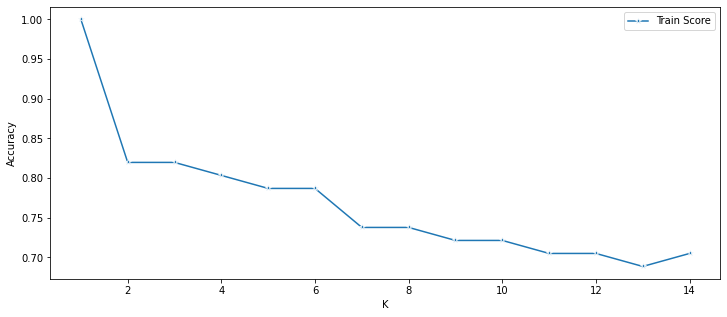

In [ ]:
#Build a KNN model
from sklearn.neighbors import KNeighborsClassifier
#Here we will manually try different k values to get the optimal value. k ranges from 1 to 15

#create an empty list to store the accuracy for each k value. This will be later used for comparison
train_scores = []

#run this for loop to find the best k value
for i in range(1,15):
    #for the current loop assign k=i
    knn = KNeighborsClassifier(i)
    #the training data
    knn.fit(X_train,y_train)
    #predict the class label for the training data
    pred_y_train=knn.predict(X_train)
    #get the training accuracy
    train_accuracy=accuracy_score(pred_y_train,y_train)
    #append the training accuracy at a particular k value to the list.
    train_scores.append(train_accuracy)

plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,15),train_scores,marker='*',label='Train Score')
plt.xlabel("K")
plt.ylabel("Accuracy")

In [ ]:
#compute our score to evaluate the performance of the fitting
number_of_neighbors = 8
knn = KNeighborsClassifier(number_of_neighbors)

knn.fit(X_train,y_train)
print (knn.score(X_test,y_test))
print (knn.score(X_train,y_train))

0.6875
0.7377049180327869


              precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       0.69      0.90      0.78        10

    accuracy                           0.69        16
   macro avg       0.68      0.62      0.61        16
weighted avg       0.68      0.69      0.66        16



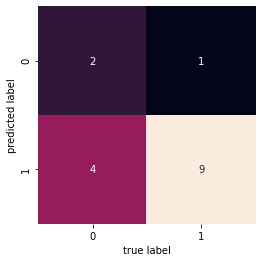

In [ ]:
#build a confusion matrix to visualize the performance of the model using seaborn
from sklearn.metrics import classification_report
y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

**XGBoost**

In [ ]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [ ]:
#Build an XGBoost model
#xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=43)    #for 3 classes
xgb_model = xgb.XGBClassifier(random_state=27)                                 #for 2 classes
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
#Use random search to come up with best set of parameters
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=27, n_iter=200, cv=5, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_train, y_train)

report_best_scores(search.cv_results_, 1)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model with rank: 1
Mean validation score: 0.687 (std: 0.100)
Parameters: {'colsample_bytree': 0.9605144176486423, 'gamma': 0.47356574160767617, 'learning_rate': 0.09754705301483349, 'max_depth': 4, 'n_estimators': 119, 'subsample': 0.623203357856742}



[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   15.5s finished


test accuracy: 0.9375
Number of mislabeled points out of a total 16 points : 1
train accuracy: 0.9836065573770492


Text(0, 0.5, 'frequency')

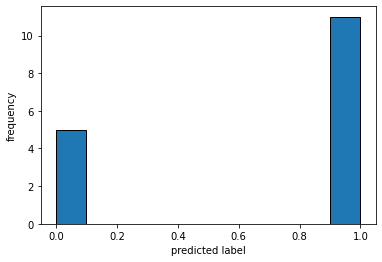

In [ ]:
xgb_tuned = xgb.XGBClassifier(colsample_bytree = 0.9605144176486423, gamma = 0.47356574160767617, learning_rate = 0.09754705301483349, max_depth = 4, n_estimators = 119, subsample= 0.623203357856742, random_state=27)
xgb_tuned.fit(X_train, y_train)
y_pred = xgb_tuned.predict(X_test)
print ('test accuracy:', accuracy_score(y_test, y_pred))
print("Number of mislabeled points out of a total %d points : %d"  % (X_test.shape[0], (y_test != y_pred).sum()))
y_hat = xgb_tuned.predict(X_train)
print ('train accuracy:', accuracy_score(y_train, y_hat))
plt.hist(y_pred,edgecolor="black")
plt.xlabel("predicted label")
plt.ylabel('frequency')

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.91      1.00      0.95        10

    accuracy                           0.94        16
   macro avg       0.95      0.92      0.93        16
weighted avg       0.94      0.94      0.94        16



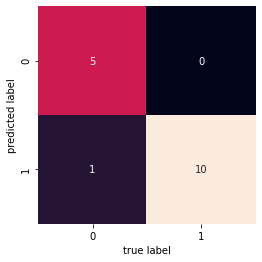

In [ ]:
#build a confusion matrix to visualize the performance of the model using seaborn
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.savefig('confusion_matrix_XGBoost.png', bbox_inches = 'tight', pad_inches = 0)

**Logistic Regression**

In [ ]:
#Logistic regression model

#import the necessary functions
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

#define an instance of the LogisticRegression class
model = LogisticRegression(penalty="l2",C=1.0,fit_intercept=True,max_iter=1000)  
'''
penalty= the regularization applied on the model. 'l1' or 'l2'
C= the inverse of regularization strength
fit_intercept= have the beta0 term as well in the equation
max_iter= maximum number of iterations
'''
#model.classes_


# fit the model on the training set
model.fit(X_train, y_train) # fit function determines the coefficients using the maximum likelihood estimate (MLE) method.

y_hat = model.predict(X_train) 

In [ ]:
#Tune the hyper parameters using the grid search

# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              #'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'penalty': ['l1', 'l2', 'elasticnet']}  
  
grid = GridSearchCV(model, param_grid, refit = True, verbose = 0, cv = 5) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 100, 'penalty': 'l2'}
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
model_tuned = LogisticRegression(penalty='l2',C=100,max_iter=1000)
model_tuned.fit(X_train,y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_hat = model_tuned.predict(X_train)
score = accuracy_score(y_train, y_hat)
print (score)
y_pred = model_tuned.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(score)

0.7868852459016393
0.75


              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.75      0.90      0.82        10

    accuracy                           0.75        16
   macro avg       0.75      0.70      0.71        16
weighted avg       0.75      0.75      0.74        16



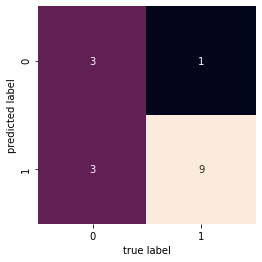

In [ ]:
#build a confusion matrix to visualize the performance of the model using seaborn
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

**Neural Network**

In [ ]:
from keras.layers import *
from keras.models import *
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm
import tensorflow as tf
tf.random.set_seed(27)

In [ ]:
def create_model(activation, optimization, init_mode, dropout_rate, neurons, weight_constraint, hidden_layers, learn_rate, loss):
    # default values
    activation='relu' # or linear
    dropout_rate=0.0 # or 0.2
    init_mode='normal'
    weight_constraint=0 # or  4
    optimizer='adam' # or SGD
    lr = 0.01
    #momemntum=0

    # create model
    neurons = 8
    number_of_classes = len(np.unique(y_test))

    model = Sequential()
    for i in range(hidden_layers):
      model.add(Dense(neurons, 
                     kernel_initializer=init_mode, 
                    activation=activation,
                    kernel_constraint=maxnorm(weight_constraint)))
      model.add(Dropout(dropout_rate)) 
    model.add(Dense(number_of_classes, kernel_initializer=init_mode, activation='softmax'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, batch_size=1000, epochs=10) 
# use verbose=0 if you do not want to see progress

########################################################
# Use scikit-learn to grid search 
activation =  ['relu']                          # , 'leaky_relu', 'tanh', 'hard_sigmoid', 'linear'  # softmax, softplus, softsign, sigmoid 
#momentum = [0.0 , 0.2]                                # , 0.4, 0.6, 0.8, 0.9
learn_rate = [0.01]                            # , 0.3, 0.001, 0.01,
dropout_rate = [0.0, 0.2]                            # 0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
weight_constraint=[1, 2]                           # , 3, 4, 5
neurons = [32, 64, 128]                                   # , 5, 10, 15, 20, 25, 30
hidden_layers = [1, 2]                             # , 2, 3  
init = ['normal']                              # 'uniform', 'lecun_uniform', 'zero', 'glorot_uniform', 'he_normal', 'he_uniform', 'glorot_normal'
optimizer = ['Adam']                            #  'SGD' , 'RMSprop', 'Adagrad', 'Adadelta', 'Adamax', 'Nadam'
loss = ['sparse_categorical_crossentropy', 'binary_crossentropy']     #'mean_squared_error', 'binary_crossentropy'
##############################################################
# grid search epochs, batch size
epochs = [20, 50, 100] # add 50, 100, 150 etc
batch_size = [1, 32, X_train.shape[0]] # add 5, 10, 20, 40, 60, 80, 100, 1000, 5000 etc
param_grid = dict(epochs=epochs, batch_size=batch_size, hidden_layers = hidden_layers, learn_rate = learn_rate, activation = activation, optimization = optimizer, init_mode = init, dropout_rate = dropout_rate, neurons = neurons, weight_constraint = weight_constraint, loss = loss)
##############################################################
k_fold = 5
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv = k_fold)
grid_result = grid.fit(X_train, y_train) 
##############################################################
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
61/61 [==============================] - 1s 2ms/step - loss: 0.6927 - accuracy: 0.5985
Epoch 2/20
61/61 [==============================] - 0s 2ms/step - loss: 0.6899 - accuracy: 0.6161
Epoch 3/20
61/61 [==============================] - 0s 2ms/step - loss: 0.6895 - accuracy: 0.5734
Epoch 4/20
61/61 [==============================] - 0s 1ms/step - loss: 0.6921 - accuracy: 0.5210
Epoch 5/20
61/61 [==============================] - 0s 2ms/step - loss: 0.6827 - accuracy: 0.6084
Epoch 6/20
61/61 [==============================] - 0s 1ms/step - loss: 0.6818 - accuracy: 0.6021
Epoch 7/20
61/61 [==============================] - 0s 1ms/step - loss: 0.6799 - accuracy: 0.6068
Epoch 8/20
61/61 [==============================] - 0s 2ms/step - loss: 0.6776 - accuracy: 0.6097
Epoch 9/20
61/61 [==============================] - 0s 2ms/step - loss: 0.6778 - accuracy: 0.6029
Epoch 10/20
61/61 [==============================] - 0s 1ms/step - loss: 0.7003 - accuracy: 0.4952
Epoch 11/20
61/61 [

Text(0, 0.5, 'Accuracy')

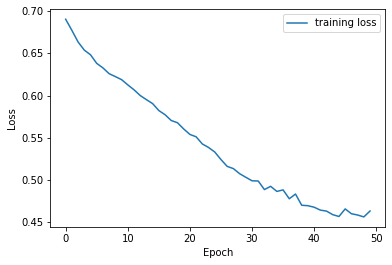

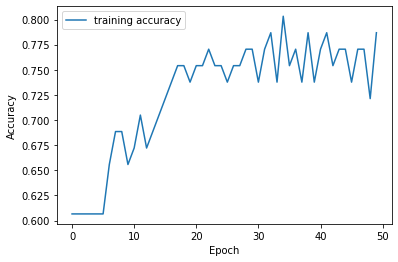

In [ ]:
#Predict using the best model
import tensorflow as tf
tf.random.set_seed(27)

activation='relu' # or linear
dropout_rate=0.0 # or 0.2
init_mode='normal'
weight_constraint=1 # or  4
optimizer='adam' # or SGD
lr = 0.01
#momemntum=0
# create model
neurons = 32
number_of_classes = len(np.unique(y_test))
hidden_layers = 1

model = Sequential()
for i in range(hidden_layers):
  model.add(Dense(neurons, 
                     kernel_initializer=init_mode, 
                    activation=activation,
                    kernel_constraint=maxnorm(weight_constraint)))
  model.add(Dropout(dropout_rate)) 
model.add(Dense(number_of_classes, kernel_initializer=init_mode, activation='softmax'))
# Compile model
model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
  
history = model.fit(X_train, y_train, epochs = 50, batch_size=1, verbose=0)
# plot the training loss vs number of epochs
plt.figure()
plt.plot(history.history['loss'],label='training loss')
plt.legend()
#plt.ylim(0, 2)
#plt.xlim(0, 20)
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure()
plt.plot(history.history['accuracy'],label='training accuracy')
plt.legend()
#plt.ylim(0, 2)
#plt.xlim(0, 20)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
# evaluate the trained model on the test dataset
y_pred = model.predict_classes(X_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print('test accuracy:', score)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


test accuracy: 0.875


              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.90      0.90      0.90        10

    accuracy                           0.88        16
   macro avg       0.87      0.87      0.87        16
weighted avg       0.88      0.88      0.88        16



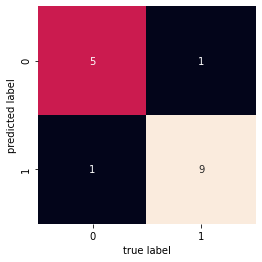

In [ ]:
#build a confusion matrix to visualize the performance of the model using seaborn
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

**Extra Tree Classifier**

In [ ]:
###Tunning Extra Trees
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
gsc = GridSearchCV(
    estimator=ExtraTreesClassifier(random_state=27),
    param_grid={
        'n_estimators': range(50,150,5),
        'criterion':['gini','entropy'],
        #'max_features': range(50,401,50),
        'min_samples_leaf': range(2,20,5),
        'min_samples_split': range(2,20,5),
    },
    scoring='accuracy',
    cv=5,
    verbose = 0
)
grid = gsc.fit(X_train, y_train)
gsc.best_params_
print(gsc.best_params_)

{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 55}


In [ ]:
#gsc.fit(X_train, y_train)
#y_hat = gsc.predict(X_train)
#y_pred = gsc.predict(X_test)
model_tuned=ExtraTreesClassifier(random_state = 27, criterion= 'gini', min_samples_leaf= 2, min_samples_split= 2, n_estimators= 55)
model_tuned.fit(X_train, y_train)
y_hat = model_tuned.predict(X_train)
y_pred = model_tuned.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"  % (X_test.shape[0], (y_test != y_pred).sum()))
# you get the conditional probabilities

Number of mislabeled points out of a total 16 points : 3


In [ ]:
#compute our score to evaluate the performance of the fitting
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred) 
print('score_test=',score)
score = accuracy_score(y_train, y_hat) 
print('score_train=',score)

score_test= 0.8125
score_train= 0.9344262295081968


              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.82      0.90      0.86        10

    accuracy                           0.81        16
   macro avg       0.81      0.78      0.79        16
weighted avg       0.81      0.81      0.81        16



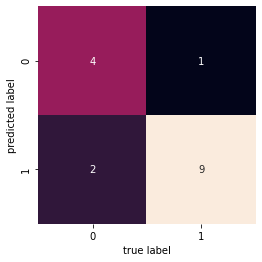

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            )
plt.xlabel('true label')
plt.ylabel('predicted label');
os.chdir('/content/drive/My Drive/AI_Thermal sytems_course_project/figures')
plt.savefig('confusion_matrix_ET.png', bbox_inches = 'tight', pad_inches = 0)